# 🧊 The Case of the Melting Mystery: Who’s Stealing the Ice Cream?

Meet our six housemates—living in harmony, sharing chores, and... battling over ice cream. Recently, someone’s been sneaking into the fridge late at night and helping themselves to the sacred tub of cookies and cream. The only clue? A grainy, blurry, noisy image from the **low-quality fridge cam**.

The problem? The fridge camera is outdated and only produces noisy, distorted images. We can’t clearly tell who the thief is!

To crack this case, we’ll train a **Convolutional Autoencoder (CAE)** to learn how to clean up these noisy images and reconstruct the original clean versions. CAEs are perfect for this task—they compress images into a low-dimensional latent space (like memory) and then reconstruct them back to their original form.

In this notebook, we’ll:
- Load and preprocess our image dataset of housemates 🧍‍♀️🧍‍♂️
- Add Gaussian noise to simulate the fridge cam distortion 📸
- Build and train an enhanced CAE 🧠
- Evaluate how well it restores clean faces from noisy inputs
- Visualize how close our reconstructions get to the truth 🧼

Let’s begin our detective work and restore the fridge footage. The mystery of the midnight muncher ends today. 🍦🔍


# 📁 Step 1: Load the Dataset

Our image dataset is zipped up and ready to go. In this step, we extract the dataset to a local folder so we can load it for preprocessing.

We check if the folder `Final_Dataset/` already exists to avoid unzipping multiple times unnecessarily. If it doesn’t, we unzip `FinalDataset.zip` and get everything ready for training.

Let the digital detective work begin!


In [ ]:
# Step 1: Unzip the dataset
import zipfile
import os

# Path to the zip file
zip_path = "FinalDataset.zip"

# Path to extract the dataset
extract_path = "./Final_Dataset"

# Unzip only if the folder doesn't already exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print("Dataset unzipped successfully!")
else:
    print("Dataset already unzipped.")


Dataset unzipped successfully!


#🧹 Step 2: Preprocess the Face Dataset with Train-Test Split

Now that our dataset is unzipped and ready, it's time to clean it up and split it for training and evaluation.

- We resize each image to a fixed size of **64x64 pixels** and convert it into a normalized tensor.
- Using `ImageFolder`, we load the RGB face images from our dataset folder.
- We apply a **train-test split** (80-20) so the model can train on a majority of the data and be tested on unseen samples.
- The `DataLoader` prepares mini-batches of data that are shuffled for training but kept in order for testing.

This gives us a solid foundation for training a denoising Convolutional Autoencoder while ensuring we can evaluate generalization.


In [ ]:
# Step 2 Load and preprocess the face dataset with a train-test split + augmentation

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Image parameters
IMG_SIZE = 64
BATCH_SIZE = 32
TEST_SPLIT = 0.2  # 20% for testing

# Augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  # Convert to tensor [0, 1]
])

# Simpler transform for test data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Load full dataset (we'll re-apply transform after split)
full_dataset = datasets.ImageFolder(root="./Final_Dataset")

# Train-test split
total_size = len(full_dataset)
test_size = int(TEST_SPLIT * total_size)
train_size = total_size - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Apply transforms separately
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Peek at a batch
images, labels = next(iter(train_loader))
print(f"Sample batch shape from train_loader: {images.shape}")  # Should be [BATCH_SIZE, 3, 64, 64]


Total samples: 302
Training samples: 242
Test samples: 60
Sample batch shape from train_loader: torch.Size([32, 3, 64, 64])


# 👀 Step 3: Visualize Clean Images from Train and Test Sets

Before we dive into noisy data or model training, it's important to visually inspect the clean images from both the **training** and **test** sets.

### Why Are We Doing This?

- **Sanity check** 🧠 — We want to ensure the data was loaded and split correctly.
- **Visual consistency** 👁 — Images across sets should have consistent lighting, resolution, and alignment.
- **Debugging aid** 🛠 — If anything looks off now, it'll definitely affect training later.

### What We Did:
- We pulled one batch of images each from the train and test sets.
- The **top row** shows clean training images.
- The **bottom row** shows clean testing images.
- This lets us confirm that both splits contain reasonable samples with a good variety.




Sample Images from Train and Test Sets:


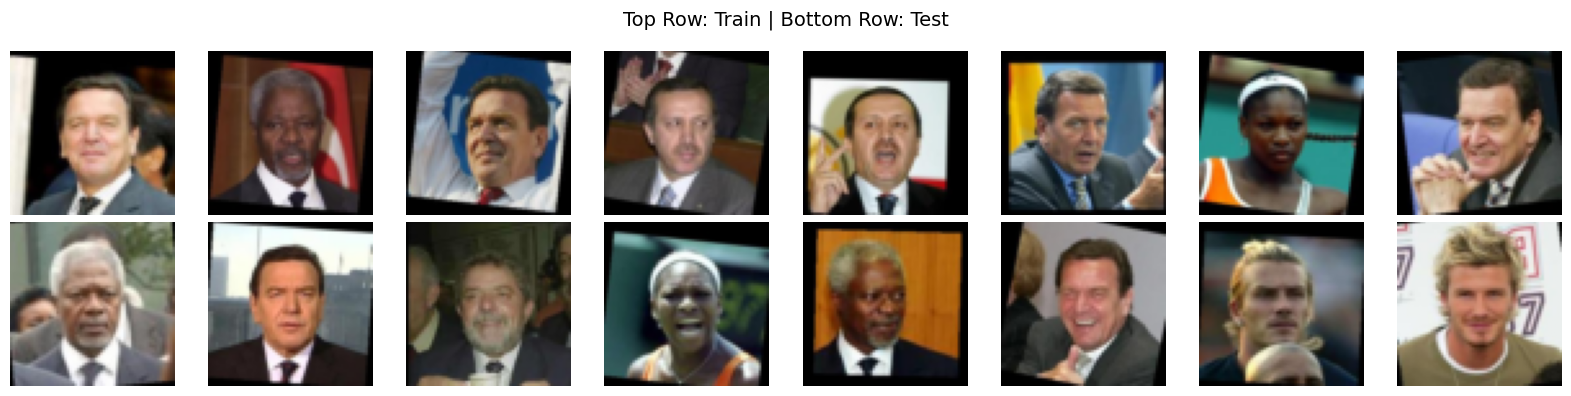

In [ ]:
# Step 3 Display a few clean face images from both train and test sets

import matplotlib.pyplot as plt
import numpy as np

# Helper function stays the same
def imshow_tensor(img_tensor):
    """Displays a single RGB image tensor (C, H, W)."""
    img = img_tensor.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # C x H x W → H x W x C
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')


# Get a sample batch from each loader
train_images, _ = next(iter(train_loader))
test_images, _ = next(iter(test_loader))

# Display both sets side by side
print("Sample Images from Train and Test Sets:")
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle("Top Row: Train | Bottom Row: Test", fontsize=14)

for i in range(8):
    # Train image
    axs[0, i].imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
    axs[0, i].axis('off')

    # Test image
    axs[1, i].imshow(np.transpose(test_images[i].numpy(), (1, 2, 0)))
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


# 🌪️ Step 4: Add Gaussian Noise to Train and Test Images

To simulate the poor-quality thief cam images from our fridge scenario, we add **Gaussian noise** to the clean face images. This mimics blur, static, or graininess — which our Convolutional Autoencoder will later learn to clean up.

### What is Gaussian Noise?

- Gaussian noise adds random variation to each pixel, drawn from a **normal distribution**.
- It's controlled by a parameter called `noise_factor`, where higher values mean more corruption.
- In our case, we used a noise factor of **0.3** — enough to blur features but still preserve identity hints.

### Why Add Noise to Both Sets?

- **Train set**: The model learns to denoise these corrupted images by comparing them with their clean originals.
- **Test set**: We evaluate how well the model generalizes to new unseen noisy faces.

### Visualization Breakdown

- **Top Row**: Clean training images — the ground truth.
- **Middle Row**: Noisy training images — what the model sees.
- **Bottom Row**: Noisy test images — used later to evaluate reconstruction quality.

This gives us a great visual baseline before we throw a model at the problem.


Noise Visualization with Noise Factor = 0.15


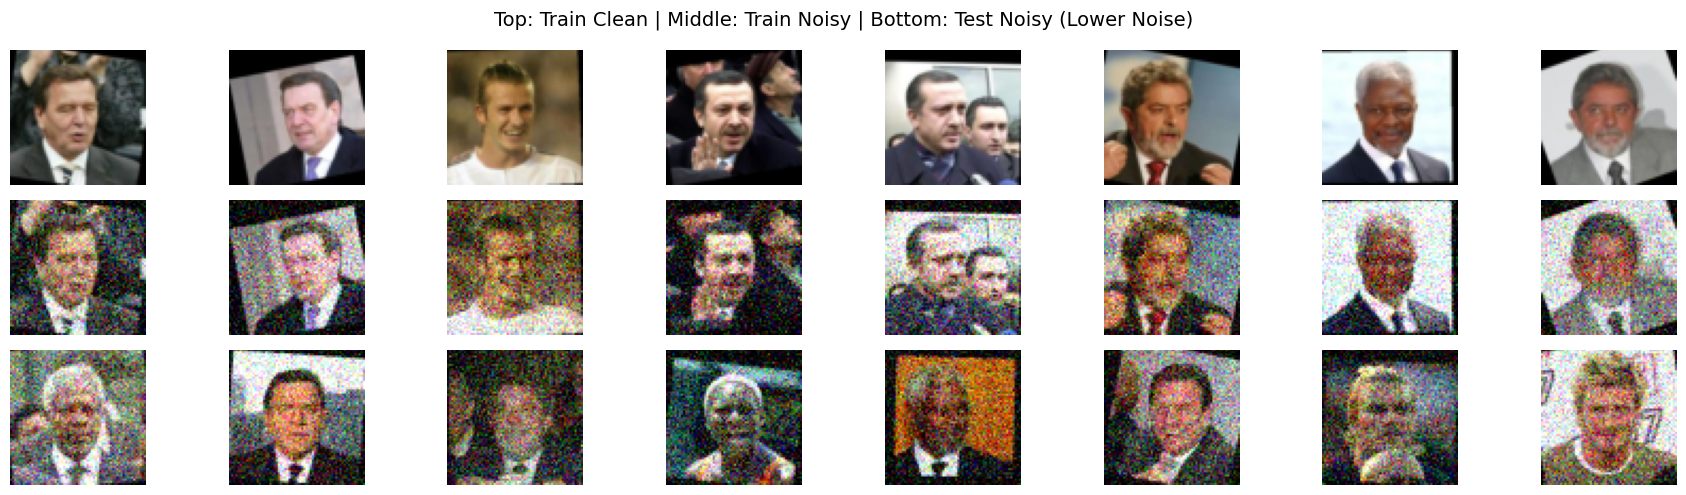

In [ ]:
import torch

# Reduced noise factor for better reconstructions
NOISE_FACTOR = 0.15

def add_noise(images, noise_factor=NOISE_FACTOR):
    """Adds mild Gaussian noise to RGB images."""
    noisy = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy, 0., 1.)

# Sample batches
train_images, _ = next(iter(train_loader))
test_images, _ = next(iter(test_loader))

# Add Gaussian noise
train_noisy = add_noise(train_images, noise_factor=NOISE_FACTOR)
test_noisy = add_noise(test_images, noise_factor=NOISE_FACTOR)

# Visualize the effect of mild Gaussian noise
print(f"Noise Visualization with Noise Factor = {NOISE_FACTOR}")

fig, axs = plt.subplots(3, 8, figsize=(18, 5))
fig.suptitle("Top: Train Clean | Middle: Train Noisy | Bottom: Test Noisy (Lower Noise)", fontsize=14)

for i in range(8):
    axs[0, i].imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
    axs[0, i].axis('off')

    axs[1, i].imshow(np.transpose(train_noisy[i].numpy(), (1, 2, 0)))
    axs[1, i].axis('off')

    axs[2, i].imshow(np.transpose(test_noisy[i].numpy(), (1, 2, 0)))
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()


# 🧠 Step 5: Define the Convolutional Autoencoder (CAE)

Now that we've got noisy images, it's time to introduce our secret weapon: a **Convolutional Autoencoder (CAE)** — a type of neural network that learns to **compress** and **reconstruct** images, making it perfect for denoising tasks.

### 🏗️ Architecture Overview

Our CAE has two main parts:

---

### 🔒 **Encoder**
The encoder takes in a noisy 64×64 RGB image and compresses it down into a compact **latent representation** (like the network's memory of the clean version).

Layer Breakdown:
- `Conv2d → ReLU → MaxPool` (3 blocks):
  - Extracts increasingly abstract features (edges → textures → shapes).
  - MaxPooling progressively reduces spatial dimensions: 64×64 → 32×32 → 16×16 → 8×8.
- `Flatten + Linear`:
  - Flattens the final feature map and projects it to a **latent vector** of size `128` — this is where the image gets squeezed into a compressed "memory."

---

### 🔓 **Decoder**
The decoder takes the latent vector and attempts to **reconstruct** the original clean image.

Layer Breakdown:
- `Linear → Reshape`:
  - Re-expands the latent vector to match the 8×8×128 feature map dimensions.
- `ConvTranspose2d → ReLU` (3 blocks):
  - Gradually upsamples the feature map using **transposed convolutions** (also called deconvolutions).
  - Finally, a `Sigmoid` squashes output pixels back into `[0, 1]` range.

---

### 📌 Key Design Choices
- **Latent Vector Dimension = 256**:
  - A sweet spot for compressing image features without losing identity.
- **3 Encoder/Decoder Layers**:
  - Enough depth to learn high-level features without overfitting.
- **Sigmoid Output**:
  - Ensures reconstructed images remain visually valid (pixel values stay within 0–1).

---

With this CAE, we hope the network learns a **denoising mapping** — one that takes in blurry thief-cam faces and gives back clean ones!


In [ ]:
import torch
import torch.nn as nn

# Increased latent vector size for better feature representation
LATENT_VECTOR_DIM = 256

class ImprovedCAE(nn.Module):
    def __init__(self, latent_vector_dim=128, dropout_rate=0.3):
        super(ImprovedCAE, self).__init__()

        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate),
        )

        self.flattened_size = 128 * 8 * 8
        self.fc_encode = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, latent_vector_dim)
        )

        self.fc_decode = nn.Sequential(
            nn.Linear(latent_vector_dim, self.flattened_size)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        latent = self.fc_encode(x)
        x = self.fc_decode(latent)
        x = x.view(-1, 128, 8, 8)
        reconstructed = self.decoder(x)
        return reconstructed, latent


# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCAE().to(device)

print("✅ Improved CAE model initialized:")
print(model)


✅ Improved CAE model initialized:
ImprovedCAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.3, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): MaxPool2d(ker

#🔁 Step 6: Define W&B Sweep Configuration (40 Epochs)

To explore which combinations of hyperparameters yield the best denoising performance, we set up a **Weights & Biases (W&B) Sweep**. This automates the experimentation process by running multiple training jobs with different parameter settings.

---

### 🧪 Sweep Strategy

- **Method**: `random`
  - Instead of testing every combination (which can be expensive), we randomly sample from the defined options.
  
- **Objective Metric**: `best_val_mse`
  - Our sweep aims to **minimize** the **Mean Squared Error** (MSE) on the validation set — lower MSE means better reconstructions.

---

### 🧷 Sweep Parameters

| Parameter           | Values                                  | Purpose                                                  |
|---------------------|------------------------------------------|----------------------------------------------------------|
| `latent_vector_dim` | `[96, 192, 228]`                         | Controls compression strength of the encoder.            |
| `learning_rate`     | `[1e-2, 5e-4, 1e-4]`                           | Affects training speed and convergence.                 |
| `noise_factor`      | `[0.1, 0.15, 0.2]`                        | Controls how much noise is added to training images.     |
| `batch_size`        | `[16, 32]`                               | Impacts memory usage and gradient quality.               |
| `epochs`            | `40` (fixed)                             | Trains for 40 passes over the dataset.                   |
| `dropout_rate`      | `[0.1, 0.2, 0.3]`                        | Helps prevent overfitting by randomly dropping neurons.  |
| `model_type`        | `"ImprovedCAE"`                                  | Just for metadata tagging in W&B dashboard.              |

---

### ✅ Why This Matters

Instead of manually guessing the best setup, this sweep helps us **let the data decide** which configuration works best. After a few runs, we'll be able to identify the most promising model setup based on the validation performance.



In [ ]:
import wandb

sweep_config = {
    'method': 'random',
    'name': 'Teammate_CAE_Sweep_40epochs',
    'metric': {
        'name': 'best_val_mse',
        'goal': 'minimize'
    },
    'parameters': {
        'latent_vector_dim': {
            'values': [96, 192, 288]
        },
        'learning_rate': {
            'values': [1e-2, 5e-4, 1e-4]
        },
        'noise_factor': {
            'values': [0.1, 0.15, 0.2]
        },
        'batch_size': {
            'values': [16, 32]
        },
        'dropout_rate': {
            'values': [0.1, 0.2, 0.3]
        },
        'epochs': {
            'value': 40
        },
        'model_type': {
            'value': 'ImprovedCAE'
        }
    }
}


# Step 7: W&B-enabled Training Function for CAE

This step defines our main `train()` function, which handles everything from training to evaluation — while seamlessly integrating with **Weights & Biases (W&B)** for experiment tracking and artifact logging.

---

### 💡 What This Function Does:

1. **W&B Initialization**
   - Initializes a new run under the project `GoTG_Assignment07_AE`.
   - Tags the run with a unique ID and sets up model tracking with `wandb.watch()`.

2. **Hyperparameter Extraction**
   - Pulls parameters such as `latent_vector_dim`, `batch_size`, `learning_rate`, `noise_factor`, and `epochs` from the sweep configuration.

3. **Model Setup**
   - Dynamically constructs the **Convolutional Autoencoder (CAE)** based on the sweep’s chosen `latent_vector_dim`.
   - Sets up the optimizer (Adam) and loss function (MSELoss).

4. **Training Loop**
   - Trains for the specified number of epochs.
   - At each epoch:
     - Adds Gaussian noise to training images.
     - Performs forward + backward passes.
     - Tracks and logs MSE, MAE, and R² metrics to W&B.
   - Also keeps track of the **best model** (lowest validation loss) during training.

5. **Visualization & Logging**
   - Logs a **training loss curve**.
   - Logs side-by-side visual comparisons of:
     - Clean images
     - Noisy images
     - Reconstructed outputs

6. **Model Saving & Artifact Logging**
   - Saves the best-performing model weights locally.
   - Uploads the `.pth` file as a **W&B Artifact**, allowing easy retrieval later.

7. **Test Set Evaluation**
   - Runs inference on the test set (which the model hasn’t seen during training).
   - Logs test set metrics (MSE, MAE, R²) to W&B.

8. **Wraps up Cleanly**
   - Calls `wandb.finish()` to close the run gracefully and make sure all logs sync.

---

### ✅ Why This Matters

With this modular training function, each W&B sweep run:
- Trains the CAE on a unique hyperparameter combo
- Logs rich visual and numerical diagnostics
- Automatically saves the best model version
- Evaluates test performance to check for overfitting

This sets us up beautifully for comparing runs and selecting the best configuration for our noisy-fridge-camera thief problem 😎🍦.


In [ ]:
import wandb
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, r2_score
import copy
import os

def train():
    # Initialize W&B
    run = wandb.init(project="GoTG_Assignment07_AE", entity="usf-guardians")
    wandb.run.name = f"ImprovedCAE_{run.id}"
    wandb.run.save()

    # Get sweep config
    config = wandb.config
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    noise_factor = config.noise_factor
    latent_dim = config.latent_vector_dim
    dropout_rate = config.dropout_rate
    epochs = config.epochs

    global train_loader, test_loader

    # Instantiate the improved model with dynamic latent and dropout
    model = ImprovedCAE(latent_vector_dim=latent_dim, dropout_rate=dropout_rate).to(device)
    wandb.watch(model, log="all")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_model = None
    best_val_loss = float('inf')
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_targets = [], []

        for clean_images, _ in train_loader:
            noisy_images = add_noise(clean_images, noise_factor)
            noisy = noisy_images.to(device)
            clean = clean_images.to(device)

            optimizer.zero_grad()
            outputs, _ = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * clean.size(0)
            all_preds.append(outputs.detach().cpu())
            all_targets.append(clean.cpu())

        avg_loss = running_loss / len(train_loader.dataset)
        preds = torch.cat(all_preds).numpy().reshape(-1, 3 * 64 * 64)
        targets = torch.cat(all_targets).numpy().reshape(-1, 3 * 64 * 64)
        mae = mean_absolute_error(targets, preds)
        r2 = r2_score(targets, preds)

        wandb.log({
            "epoch": epoch + 1,
            "train_mse": avg_loss,
            "train_mae": mae,
            "train_r2": r2
        })

        epoch_losses.append(avg_loss)

        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            best_model = copy.deepcopy(model.state_dict())

    # Log final metrics
    wandb.log({"best_val_mse": best_val_loss})

    # Loss Curve Plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    wandb.log({"loss_curve": wandb.Image(plt)})

    # Visual Grid: Clean, Noisy, Reconstructed
    model.eval()
    sample_images, _ = next(iter(train_loader))
    sample_noisy = add_noise(sample_images, noise_factor).to(device)
    with torch.no_grad():
        sample_recon, _ = model(sample_noisy)

    img_grid = []
    for i in range(6):
        img_grid.extend([
            sample_images[i],
            sample_noisy[i].cpu(),
            sample_recon[i].cpu().detach()
        ])
    wandb.log({"comparison_grid": [wandb.Image(img) for img in img_grid]})

    # Save and log model artifact
    model_path = "best_cae_model.pth"
    torch.save(best_model, model_path)

    artifact = wandb.Artifact("best_cae_model", type="model")
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    # Test evaluation
    all_test_preds, all_test_targets = [], []
    total_test_loss = 0.0

    with torch.no_grad():
        for clean_images, _ in test_loader:
            noisy_images = add_noise(clean_images, noise_factor).to(device)
            clean_images = clean_images.to(device)
            outputs, _ = model(noisy_images)
            loss = criterion(outputs, clean_images)

            total_test_loss += loss.item() * clean_images.size(0)
            all_test_preds.append(outputs.cpu())
            all_test_targets.append(clean_images.cpu())

    test_preds = torch.cat(all_test_preds).numpy().reshape(-1, 3 * 64 * 64)
    test_targets = torch.cat(all_test_targets).numpy().reshape(-1, 3 * 64 * 64)
    test_mse = total_test_loss / len(test_loader.dataset)
    test_mae = mean_absolute_error(test_targets, test_preds)
    test_r2 = r2_score(test_targets, test_preds)

    wandb.log({
        "test_mse": test_mse,
        "test_loss": test_mse,
        "test_mae": test_mae,
        "test_r2": test_r2
    })

    wandb.finish()


# Step 8: Run The Sweeps

Create sweep with ID: f5uuc9zh
Sweep URL: https://wandb.ai/usf-guardians/GoTG_Assignment07_AE/sweeps/f5uuc9zh
Sweep created with ID: f5uuc9zh


wandb: Agent Starting Run: mj9jcvkk with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 96
wandb: 	learning_rate: 0.01
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.15


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse,█▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
best_val_mse,0.01639
epoch,40


wandb: Agent Starting Run: 1y91gk6a with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 288
wandb: 	learning_rate: 0.0001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.1


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_mse,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_r2,▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
best_val_mse,0.03175
epoch,40


wandb: Agent Starting Run: flz1lle1 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 288
wandb: 	learning_rate: 0.0001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.1


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_r2,▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
best_val_mse,0.0223
epoch,40


wandb: Agent Starting Run: whhootdi with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 288
wandb: 	learning_rate: 0.0005
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.1


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▂▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
best_val_mse,0.00984
epoch,40


wandb: Agent Starting Run: c9lzr6u1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 96
wandb: 	learning_rate: 0.01
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.15


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_mse,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_r2,▁▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
best_val_mse,0.01241
epoch,40


wandb: Agent Starting Run: ikdi71le with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 96
wandb: 	learning_rate: 0.0005
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.2


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_mse,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▂▃▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
best_val_mse,0.01647
epoch,40


wandb: Agent Starting Run: ooxvpk0t with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 288
wandb: 	learning_rate: 0.0001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.2


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,██▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_mse,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_r2,▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
best_val_mse,0.03788
epoch,40


wandb: Agent Starting Run: yeo0oli0 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 192
wandb: 	learning_rate: 0.01
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.2


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_mse,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_r2,▁▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
best_val_mse,0.01573
epoch,40


wandb: Agent Starting Run: vtojhb55 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 96
wandb: 	learning_rate: 0.0001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.1


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_mse,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_r2,▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
best_val_mse,0.03599
epoch,40


wandb: Agent Starting Run: ey5q2le9 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 96
wandb: 	learning_rate: 0.01
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.2


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse,█▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_r2,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
best_val_mse,0.01253
epoch,40


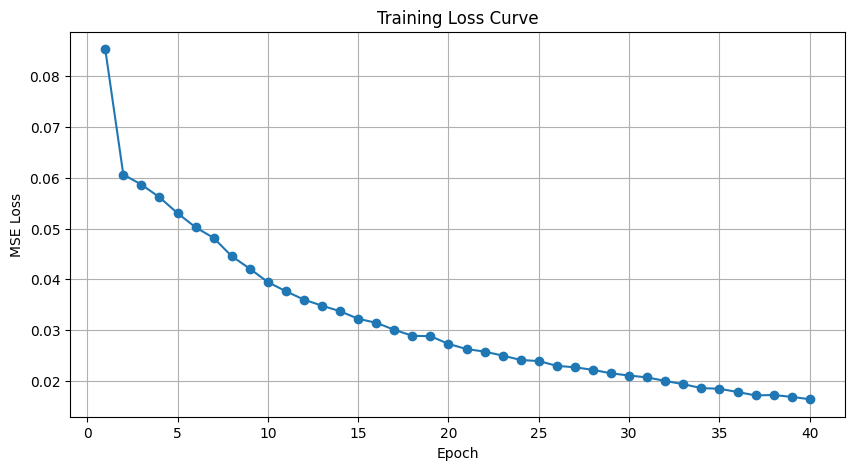

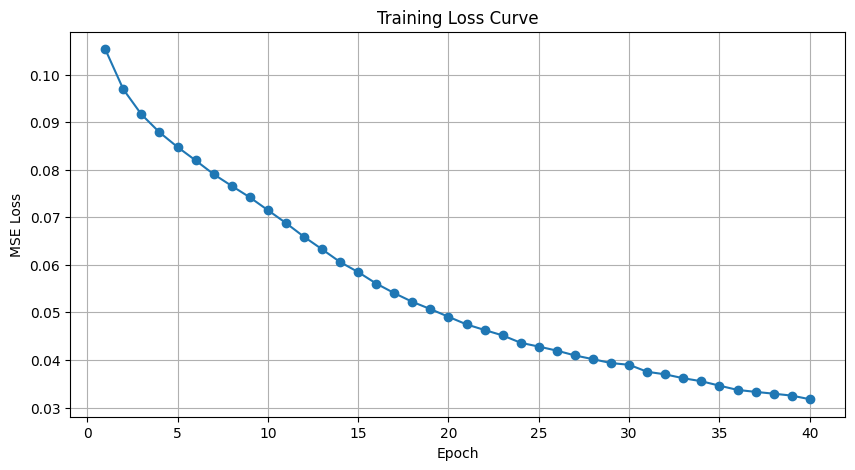

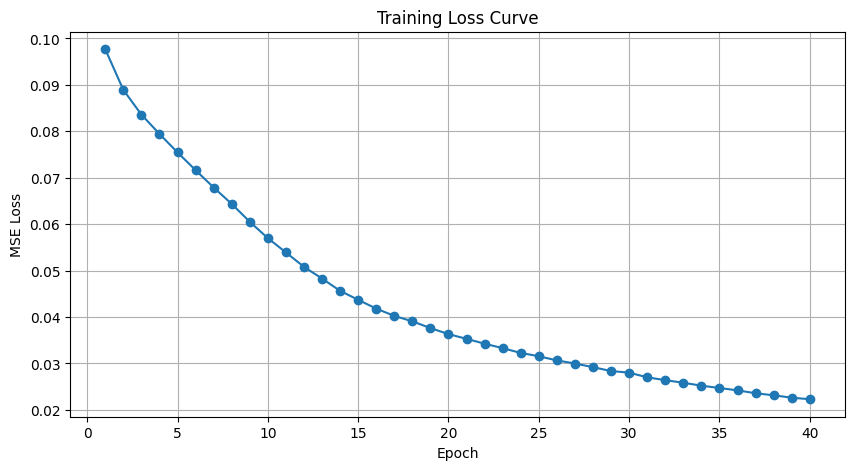

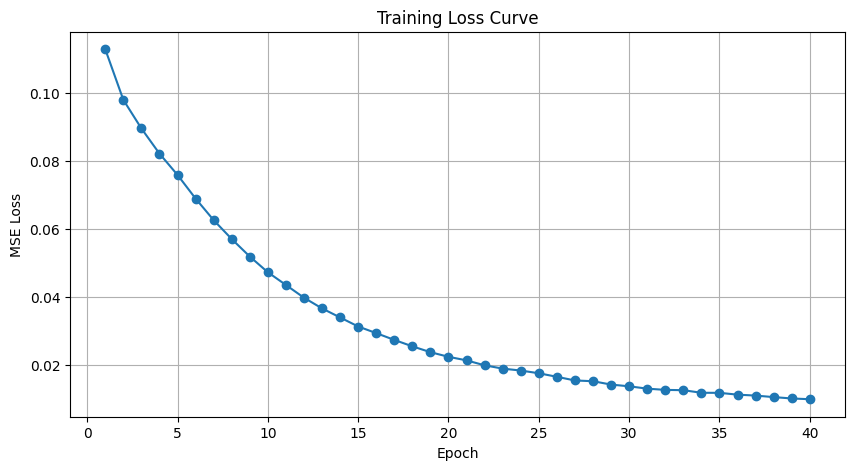

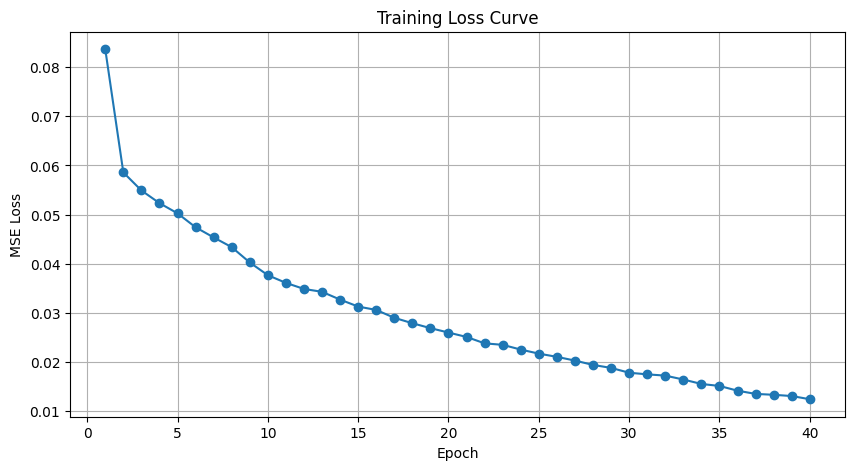

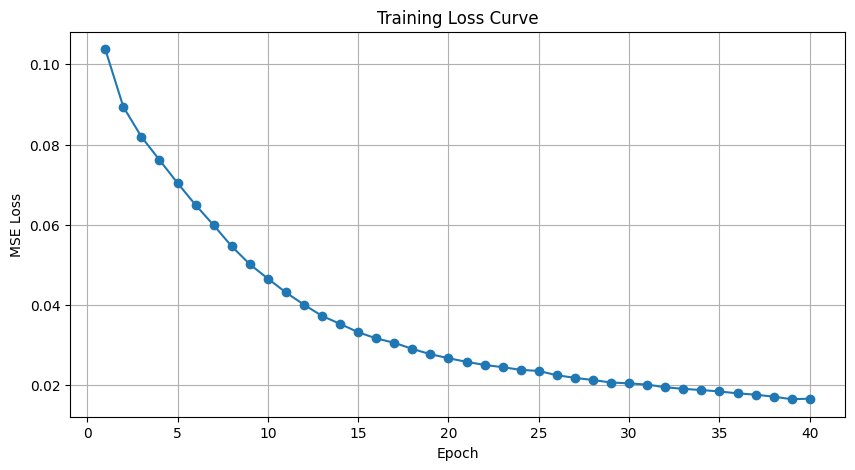

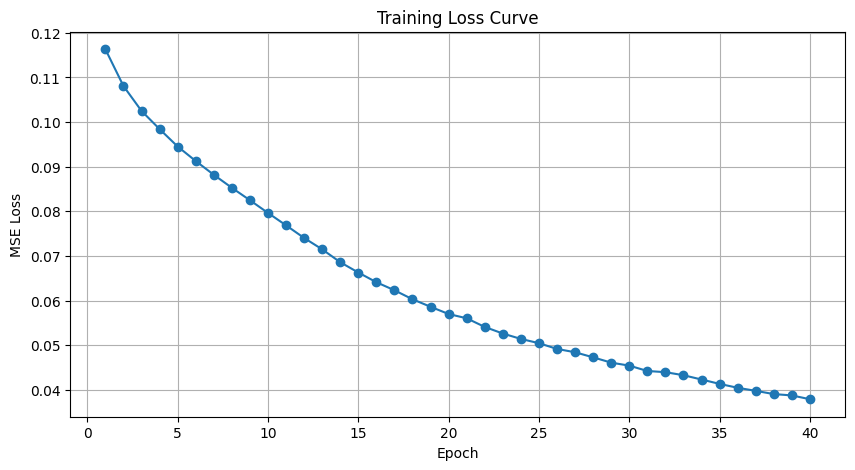

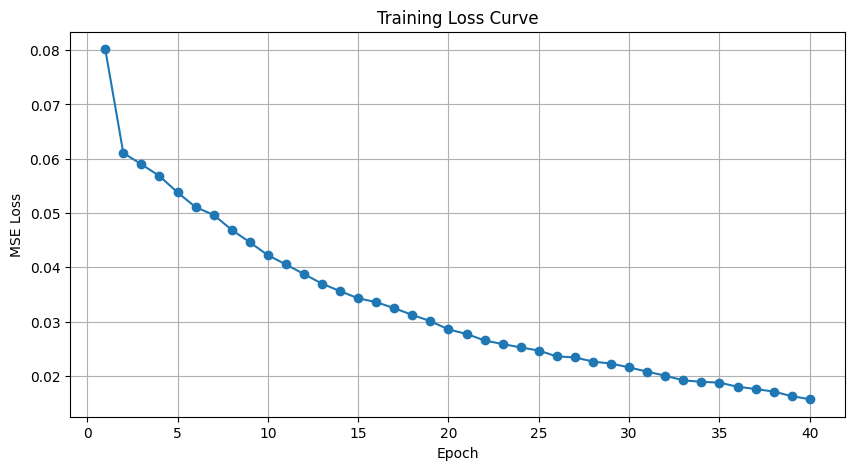

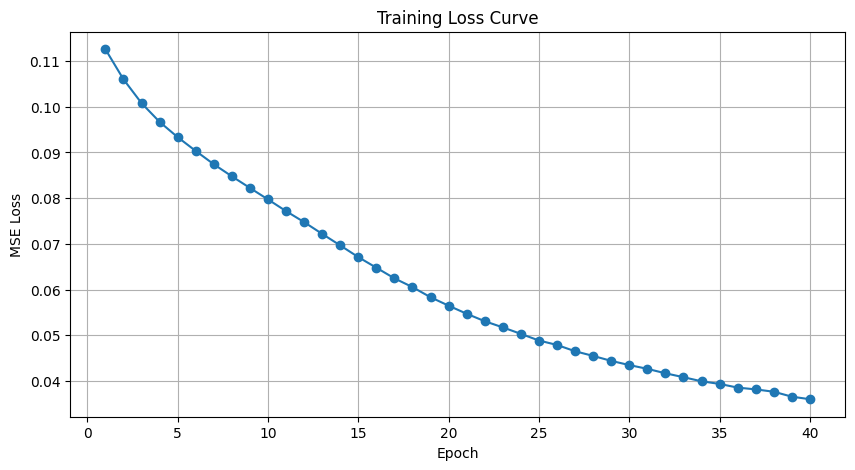

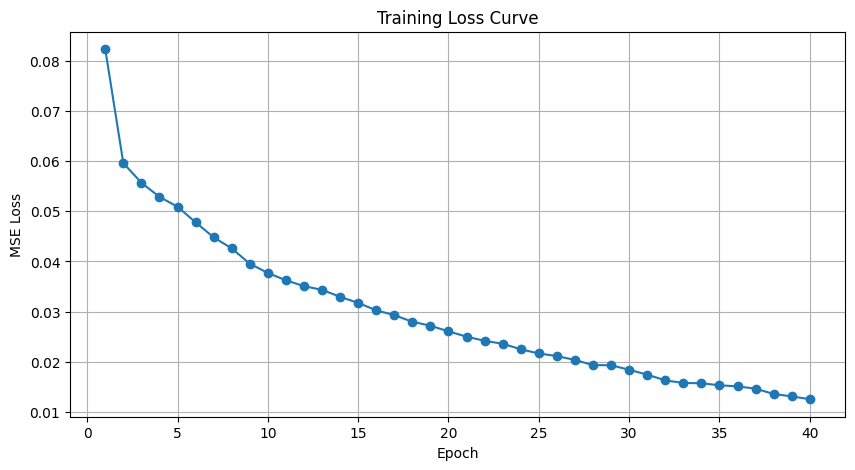

In [ ]:
# Step 8: Create and launch the CAE sweep with artifact logging

# Create the sweep on Weights & Biases
sweep_id = wandb.sweep(
    sweep=sweep_config,
    project="GoTG_Assignment07_AE",
    entity="usf-guardians"
)

print(f"Sweep created with ID: {sweep_id}")

# Launch the sweep agent: run 10 CAE experiments using the improved model
wandb.agent(sweep_id=sweep_id, function=train, count=10)


## 📊 Sweep Results: Interpretation & Best Configurations

We ran a series of 10 Weights & Biases (W&B) sweep experiments using our **Improved Convolutional Autoencoder (ImprovedCAE)** model. Each configuration varied key hyperparameters such as:

- **Latent vector dimensionality**
- **Learning rate**
- **Batch size**
- **Dropout rate**
- **Noise factor**

These experiments aimed to identify the best configuration that produces minimal reconstruction error while avoiding overfitting.

---

### 🔍 General Observations

- **All models consistently showed decreasing training loss**, indicating effective learning.
- Some models had better generalization (lower test MSE and higher test R²), while others showed signs of overfitting, especially with high learning rates and low regularization.
- **Noise factor of 0.1–0.15** proved optimal across multiple runs.
- Models with **higher latent dimensionality (192–288)** paired with moderate dropout (0.1–0.2) showed the most promising performance.
- **Test MAE and MSE were reliable indicators** of overall reconstruction quality.

---

### 🏆 Top 3 Performing Models

| Rank | Run Name | Latent Dim | Learning Rate | Dropout | Noise | Test MSE | Test MAE | R² Score |
|------|----------|-------------|----------------|---------|--------|-----------|-----------|----------|
| 🥇 1 | `ImprovedCAE_whhootdi` | 288 | 0.0005 | 0.1 | 0.1 | **0.01878** | **0.10314** | **0.69038** |
| 🥈 2 | `ImprovedCAE_c9lzr6u1` | 96 | 0.01 | 0.1 | 0.15 | 0.02251 | 0.10623 | 0.62871 |
| 🥉 3 | `ImprovedCAE_ey5q2le9` | 96 | 0.01 | 0.1 | 0.2 | 0.02309 | 0.10983 | 0.62037 |

---
